# VGG16, EfficientNet e ResNet50 - Treinamento com Data Augmentation
Este notebook aplica as redes **VGG16**, **EfficientNet** e **ResNet50** utilizando os dados já separados em treino, validação e teste pelo dataset, com data augmentation nos dados de treino.

# Importações Necessárias

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input

# Imports de classes dentro do projeto
from get_data_from_db import DataLoader
from create_model import create_vgg_model, create_efficientnet_model, create_resnet_model

C:\Users\Matheus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Função para Carregar e Processar Dados

In [2]:
def load_and_process_data(data_loader, data_type='train'):
    """
    Carrega e processa os dados de acordo com o tipo especificado.
    
    Args:
        data_loader: Instância do DataLoader
        data_type: 'train', 'val' ou 'test'
    
    Returns:
        X, y: Arrays numpy com as imagens e labels processados
    """
    IMG_SIZE = (224, 224)
    
    if data_type == 'train':
        data_with_labels = data_loader.get_train_data()
        paths = {
            0: data_loader.train_normal_path,
            1: data_loader.train_ulcerative_colitis_path,
            2: data_loader.train_polyps_path,
            3: data_loader.train_esophagitis_path
        }
    elif data_type == 'val':
        data_with_labels = data_loader.get_val_data()
        paths = {
            0: data_loader.val_normal_path,
            1: data_loader.val_ulcerative_colitis_path,
            2: data_loader.val_polyps_path,
            3: data_loader.val_esophagitis_path
        }
    elif data_type == 'test':
        data_with_labels = data_loader.get_test_data()
        paths = {
            0: data_loader.test_normal_path,
            1: data_loader.test_ulcerative_colitis_path,
            2: data_loader.test_polyps_path,
            3: data_loader.test_esophagitis_path
        }
    else:
        raise ValueError("data_type deve ser 'train', 'val' ou 'test'")
    
    print(f"Total de amostras de {data_type}: {len(data_with_labels)}")
    
    X, y = [], []
    
    for filename, label in data_with_labels:
        if label not in paths:
            continue
            
        filepath = os.path.join(paths[label], filename)
        
        img = cv2.imread(filepath)
        if img is None:
            print(f"[AVISO] Não foi possível carregar: {filepath}")
            continue
        
        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        y.append(label)
    
    X = np.array(X, dtype="float32") / 255.0  # Normalização padrão
    y = to_categorical(np.array(y), num_classes=4)
    
    print(f"Formato de X_{data_type}: {X.shape}")
    print(f"Formato de y_{data_type}: {y.shape}")
    
    return X, y

# Configuração do Data Augmentation

In [3]:
# Configurando o ImageDataGenerator para data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,          # Rotação aleatória até 20 graus
    width_shift_range=0.1,      # Deslocamento horizontal de até 10%
    height_shift_range=0.1,     # Deslocamento vertical de até 10%
    shear_range=0.1,            # Transformação de cisalhamento
    zoom_range=0.1,             # Zoom aleatório de até 10%
    horizontal_flip=True,       # Espelhamento horizontal
    vertical_flip=False,        # Sem espelhamento vertical (não recomendado para imagens médicas)
    fill_mode='nearest',        # Preenchimento de pixels
    brightness_range=[0.8, 1.2] # Variação de brilho
)

print("Data Augmentation configurado com os seguintes parâmetros:")
print("- Rotação: ±20 graus")
print("- Deslocamento: ±10%")
print("- Cisalhamento: 10%")
print("- Zoom: ±10%")
print("- Espelhamento horizontal: Sim")
print("- Variação de brilho: 80% - 120%")

Data Augmentation configurado com os seguintes parâmetros:
- Rotação: ±20 graus
- Deslocamento: ±10%
- Cisalhamento: 10%
- Zoom: ±10%
- Espelhamento horizontal: Sim
- Variação de brilho: 80% - 120%


# Carregando os Dados

In [4]:
# Inicializa o DataLoader
data_loader = DataLoader()

# Carrega os dados de treino, validação e teste separadamente
X_train, y_train = load_and_process_data(data_loader, 'train')
X_val, y_val = load_and_process_data(data_loader, 'val')
X_test, y_test = load_and_process_data(data_loader, 'test')

# Aplica o data augmentation apenas nos dados de treino
print("\nAplicando data augmentation nos dados de treino...")
datagen.fit(X_train)
print("Data augmentation configurado!")

Dataset downloaded/cached at: C:\Users\Matheus\.cache\kagglehub\datasets\francismon\curated-colon-dataset-for-deep-learning\versions\1
Total de amostras de train: 3200
Formato de X_train: (3200, 224, 224, 3)
Formato de y_train: (3200, 4)
Total de amostras de val: 2000
Formato de X_val: (2000, 224, 224, 3)
Formato de y_val: (2000, 4)
Total de amostras de test: 800
Formato de X_test: (800, 224, 224, 3)
Formato de y_test: (800, 4)

Aplicando data augmentation nos dados de treino...
Data augmentation configurado!


## Treinando com ResNet50 (com Data Augmentation)

In [5]:
print("Treinando ResNet50 com Data Augmentation...")

# Prepara dados com pré-processamento específico da ResNet50
X_val_res = preprocess_input(X_val * 255.0)
X_test_res = preprocess_input(X_test * 255.0)

# Cria o modelo ResNet50
resnet_model = create_resnet_model(input_shape=(224, 224, 3), num_classes=4)

# Configura o data augmentation para ResNet50 (necessário reprocessar)
datagen_resnet = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    preprocessing_function=lambda x: preprocess_input(x)  # Aplica o preprocess da ResNet50
)

# Treina o modelo usando o gerador de dados com augmentation
history_res = resnet_model.fit(
    datagen_resnet.flow(X_train * 255.0, y_train, batch_size=32),  # Multiplica por 255 para reverter normalização
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=(X_val_res, y_val),
    verbose=1
)

# Avalia no conjunto de validação
val_loss_res, val_acc_res = resnet_model.evaluate(X_val_res, y_val, verbose=0)
print(f"[ResNet50 - VALIDAÇÃO] Loss: {val_loss_res:.4f}, Acurácia: {val_acc_res:.4f}")

Treinando ResNet50 com Data Augmentation...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


C:\Users\Matheus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.8759 - loss: 4.5166 - val_accuracy: 0.8265 - val_loss: 1.6115
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.9375 - loss: 0.4432 - val_accuracy: 0.7470 - val_loss: 2.3915
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.9444 - loss: 0.2434 - val_accuracy: 0.8845 - val_loss: 0.5250
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.9431 - loss: 0.2219 - val_accuracy: 0.9255 - val_loss: 0.2842
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.9447 - loss: 0.2464 - val_accuracy: 0.9130 - val_loss: 0.4848
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.9375 - loss: 0.3797 - val_accuracy: 0.8560 - val_loss: 0.8484
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.9575 - loss: 0.2101 - val_accuracy: 0.9195 - val_loss: 0.2847
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.9575 - loss: 0.1775 - val_accu

## Testando ResNet50

In [6]:
# Avalia o modelo ResNet50 no conjunto de teste
test_loss_res, test_acc_res = resnet_model.evaluate(X_test_res, y_test, verbose=1)
print(f"[ResNet50 - TESTE] Loss: {test_loss_res:.4f}, Acurácia: {test_acc_res:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9150 - loss: 0.3246
[ResNet50 - TESTE] Loss: 0.3246, Acurácia: 0.9150


25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step


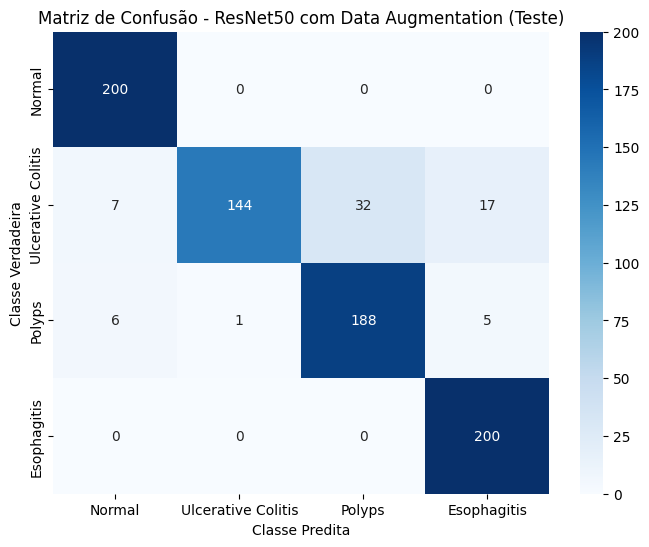


Relatório de Classificação - ResNet50 com Data Augmentation:
                    precision    recall  f1-score   support

            Normal       0.94      1.00      0.97       200
Ulcerative Colitis       0.99      0.72      0.83       200
            Polyps       0.85      0.94      0.90       200
       Esophagitis       0.90      1.00      0.95       200

          accuracy                           0.92       800
         macro avg       0.92      0.92      0.91       800
      weighted avg       0.92      0.92      0.91       800



In [7]:
# Fazer as predições no conjunto de teste
predicoes_resnet = resnet_model.predict(X_test_res, verbose=1)

# Converter as predições de one-hot encoding para labels
y_pred_resnet = np.argmax(predicoes_resnet, axis=1)

# Converter os verdadeiros labels de one-hot encoding para labels
y_true_resnet = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)

# Definir os nomes das classes
classes = ["Normal", "Ulcerative Colitis", "Polyps", "Esophagitis"]

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.title('Matriz de Confusão - ResNet50 com Data Augmentation (Teste)')
plt.show()

# Exibir relatório de classificação
print("\nRelatório de Classificação - ResNet50 com Data Augmentation:")
print(classification_report(y_true_resnet, y_pred_resnet, target_names=classes))

In [8]:
# Adicione esta célula no final do seu notebook 'main3.ipynb'
model_save_path = 'resnet50_colon_model.h5'
resnet_model.save(model_save_path)
print(f"Modelo salvo em: {model_save_path}")

Modelo salvo em: resnet50_colon_model.h5
